# Lesson 3

# Random variables to random vectors to random functions

In this lesson we'll progress through random variables to random vectors to random functions.  We'll find at the end that we've fit our first GP!

In [1]:
import arviz as az
import aesara.tensor as at
import pandas as pd
import pymc as pm
import pymc.sampling_jax
import matplotlib.pyplot as plt
import numpy as np

/Users/andre/miniconda3/envs/intuitive_bayes/lib/python3.10/site-packages/aesara/link/jax/dispatch.py:87: UserWarning: JAX omnistaging couldn't be disabled: Disabling of omnistaging is no longer supported in JAX version 0.2.12 and higher: see https://github.com/google/jax/blob/main/docs/design_notes/omnistaging.md.
  warnings.warn(f"JAX omnistaging couldn't be disabled: {e}")
/Users/andre/miniconda3/envs/intuitive_bayes/lib/python3.10/site-packages/pymc/sampling_jax.py:36: UserWarning: This module is experimental.
  warnings.warn("This module is experimental.")


# Section 10: Random variables

You've already learned about random variables, so we won't dwell on this step.  Below we draw 10k samples from a normal random variable.

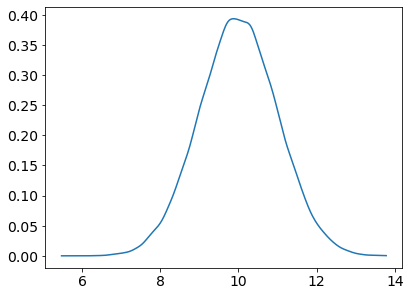

In [2]:
theta = pm.draw(pm.Normal.dist(mu=10, sigma=1), 50_000)

az.plot_dist(theta);

## Now let's generalize to random vectors

In this first example, the distinction between random vector and random variable is just semantic.  A random vector at it's simplest is just random variables stuck together.  

In [3]:
# Make three random variables, put them into a vector
theta1 = pm.Normal.dist(mu=4, sigma=1)
theta2 = pm.Normal.dist(mu=2, sigma=2)
theta3 = pm.Normal.dist(mu=6, sigma=0.5)

# Stick the three random variables together into a random vector
random_vector = [theta1, theta2, theta3]

# Draw samples from the random vector
samples = pm.draw(at.as_tensor_variable(random_vector), draws=10_000)
print("Shape of samples:", samples.shape)

Shape of samples: (10000, 3)


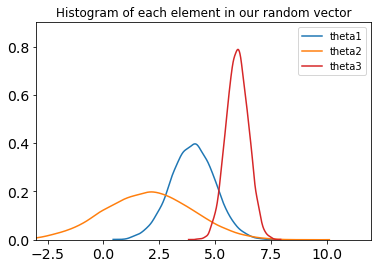

In [4]:
colors = ["C0", "C1", "C3"]

for i in range(3):
    az.plot_dist(samples[:, i], color=colors[i], label="theta" + str(i+1))

plt.title("Histogram of each element in our random vector");
plt.xlim([-3, 12]);
plt.ylim([0.0, 0.9]);

The last example is a trivial case because there is no relationship between the three random variables.  To become a random vector, all we did was stick them together into a list and start thinking about them as something that works together as one "unit".  Usually though, there's not much of a point of talking about random vectors when their random variables have no relationship.  

## Section Recap
* Random variables are mathematical concepts typically denoted $x$
  * A single random draw is one _realized_ number 
* Random variables can be grouped together in random vectors, typically denoted in uppercase as $X$
  * A single random draw generates a vector of realized numbers
  * In our case we got 3
* Random variables can be represented as objects
  * In PyData stack typically scipy and numpy can bve used to instantiate random variables
  * We use Aesara as it provides extra functionality for Bayesian inference


# Sec 20: Multivariate normals

The most important type of random vector for this course is the multivariate normal.  **A multivariate normal distribution is a set of normal random, like the above example, but, they have correlations between each other -- they are not independent**.  In this section, we are going to intuitively describe multivariate normals.  Like kernels, MvNs are a key building block in Gaussian processes.  They're the "Gaussian" part, after all.  

It's important to start by saying that multivariate normals are a generalization of univariate normals.  Meaning, it's equivalent to describe a set of univariate (like the ones above) distributions as a special type of the multivariate case.

What does this look like?  Let's start with the simplest case.  A two dimensional multivariate normal.  We'll start here because it's possible to visualize it in two dimensions.  Lets plot samples for two normal random variables that are independent on a scatterplot.  

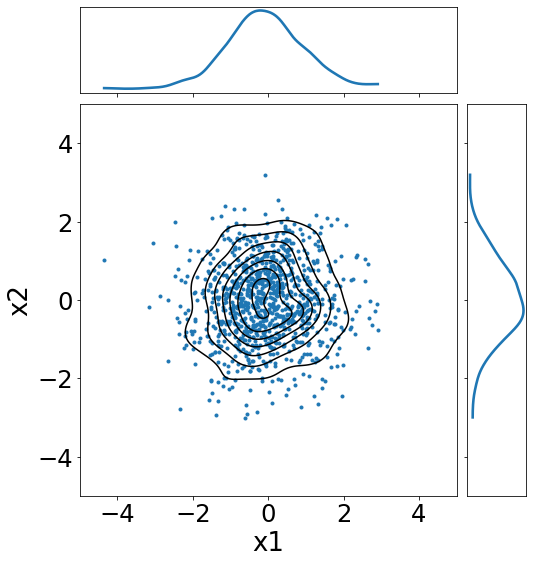

In [6]:
mu = 0.0
sigma = 1.0

x1 = pm.draw(pm.Normal.dist(mu=mu, sigma=sigma), 1000)
x2 = pm.draw(pm.Normal.dist(mu=mu, sigma=sigma), 1000)

axs = az.plot_pair(
    {"x1": x1, "x2": x2},
    kind=["scatter", "kde"],
    marginals=True,
    figsize=(8, 9),
); axs = axs.flatten()

axs[2].set_xlim([-5, 5])
axs[2].set_ylim([-5, 5]);

Notice that I took care to make the figure a square, and to set the axis limits.  Feel free to rerun this code a few times, and draw more samples.  You'll see that the scatter plot always makes a perfect circle -- if you were to sample infinitely of course.  On the top and on the right there are two other plots verifying that this is in fact two, one dimensional normals.  This is the equation for the probability density function for a univariate normal (you've probably seen this before):

$$
p(x \mid \mu, \sigma) = \frac{1}{\sigma\sqrt{2\pi}} \exp\left[ \frac{(x - \mu)^2}{2\sigma^2} \right]
$$
You may not have noticed that factor of $2\pi$ in the denominator.  $\pi$ is of course, all about circles. There are interesting mathematical connections between normals and circles, but we won't get into that here.  You may find that some people describe multivariate normals as "spherical", or as having some amount of "sphericity".  To show why they say this, let's add a dimension and turn our 2d scatterplot into a 3d scatterplot.

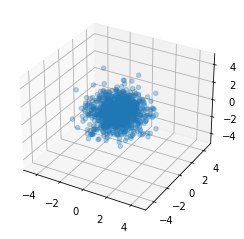

In [7]:
x3 = pm.draw(pm.Normal.dist(mu=mu, sigma=sigma), 1000)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(x1, x2, x3, alpha=0.3);

ax.set_xlim([-5, 5])
ax.set_ylim([-5, 5]);
ax.set_zlim([-5, 5]);

### Spheres

Instead of a circle, now it's a sphere!  It's really very difficult to imagine, but try and picture in your mind what this would look like if you added, one more dimension.  You go from a circle in 2d, to a sphere in 3d, to a "sphere" in 4d (you could call it a hypersphere if you want to sound, extra nerdy).  We live in a 3 dimensional world (4 if you count time, which unlike the other three dimensions, seems to only go one way), so I don't want to say it's impossible to picture this round blob in 4 dimensions, because maybe someone out there can, but I can't.  I do think it's important to try though, and to sort of see if you can get a sense of it.

It's an important concept to at least try and wrap your brain around, because spoiler alert: Gaussian processes are actually *infinite* dimensional.  It is important to have some sense of what this means when working with them and developing models with them.  Also, the result of any Bayesian model is actually a high dimensional posterior distribution.  Many hurdles that you face working with real data, flow down from the fact that high dimensional things are difficult to visualize and tricky to deal with.  Even so, having some intuition here means that you can tackle problems and that may have seemed impossible before! 

Thanks for coming to my TED talk.  Since we have work to do and lives to live, let's come back to the mortal plane.  Circles and spheres are cool and all, but let's make make a two dimensional multivariate normal, where there is some dependence between `x1` and `x2`.  You've understand the mean and variance or standard deviation parameters, but we'll need one more parameter, the covariance.  **The covariance parameter describes how strongly two random variables change together -- how much they co-vary**.  Let's draw some samples, show a 2d scatterplot, and then unpack what we're looking at.

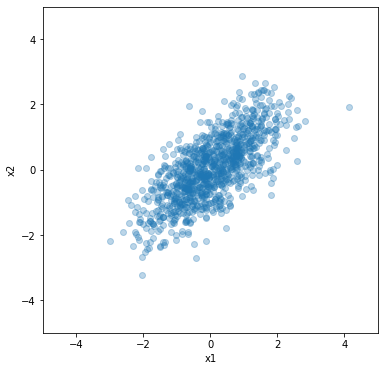

In [40]:
mu = [0.0, 0.0]
sigma1 = 1.0
sigma2 = 1.0
covariance = 0.7
cov = np.array([
    [sigma1, covariance],
    [covariance, sigma2]
])
samples = pm.draw(pm.MvNormal.dist(mu=mu, cov=cov), 1000)

x1 = samples[:, 0]
x2 = samples[:, 1]

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.scatter(x1, x2, alpha=0.3)
ax.set_xlim([-5, 5])
ax.set_ylim([-5, 5]);
ax.set_xlabel("x1");
ax.set_ylabel("x2");

Instead of a perfect circle, we've now got a diagonal band.  The main new thing you might see here is `cov`.  This is the covariance matrix.  The covariance matrix is a square array of numbers, so there are always an equal number of rows and columns.  There is one row and one column per dimension.  That's why `cov` in this example is two by two.  Each row and each column correspond to one of the dimensions.  

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  overflow:hidden;padding:10px 5px;word-break:normal;}
.tg th{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  font-weight:normal;overflow:hidden;padding:10px 5px;word-break:normal;}
.tg .tg-c3ow{border-color:inherit;text-align:center;vertical-align:top}
.tg .tg-0pky{border-color:inherit;text-align:left;vertical-align:top}
</style>
<table class="tg">
<thead>
  <tr>
    <th class="tg-0pky"></th>
    <th class="tg-c3ow"><span style="font-weight:bold">Dimension 1</span></th>
    <th class="tg-c3ow"><span style="font-weight:bold">Dimension 2</span></th>
  </tr>
</thead>
<tbody>
  <tr>
    <td class="tg-0pky"><span style="font-weight:bold">Dimension 1</span></td>
    <td class="tg-c3ow">$\sigma^2_{11}$</td>
    <td class="tg-c3ow">$\sigma^2_{12}$</td>
  </tr>
  <tr>
    <td class="tg-0pky"><span style="font-weight:bold">Dimension 2</span></td>
    <td class="tg-c3ow">$\sigma^2_{12}$</td>
    <td class="tg-c3ow">$\sigma^2_{22}$</td>
  </tr>
</tbody>
</table>

If you return to the scatterplot above, you'll see we used the positive value of 0.7.  The fact that this value is positive means, when x1 is large, its more likely that x2 is also large.  Lets cover the left two thirds of the plot:

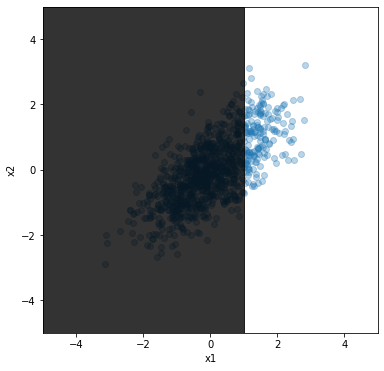

In [41]:
from matplotlib.patches import Rectangle

mu = [0.0, 0.0]
sigma1 = 1.0
sigma2 = 1.0
covariance = 0.7
cov = np.array([
    [sigma1, covariance],
    [covariance, sigma2]
])
samples = pm.draw(pm.MvNormal.dist(mu=mu, cov=cov), 1000)

x1 = samples[:, 0]
x2 = samples[:, 1]

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.scatter(x1, x2, alpha=0.3)
ax.set_xlim([-5, 5])
ax.set_ylim([-5, 5])
ax.set_xlabel("x1");
ax.set_ylabel("x2");

ax.add_patch(Rectangle((-5, -5), 6, 10, alpha=0.8, color="k"));

You can see it now, when `x2` is "large", meaning here, above 1, then the points usually are larger values of `x2`.  I'm using the word "usually" on purpose.  Some amount of covariance doesn't guarantee this to be true, it just makes it more likely.  However, the larger values of covariance, the more likely this is true.  To see that this is true, let's take a look at this when the covariance is one, equal to the variance:

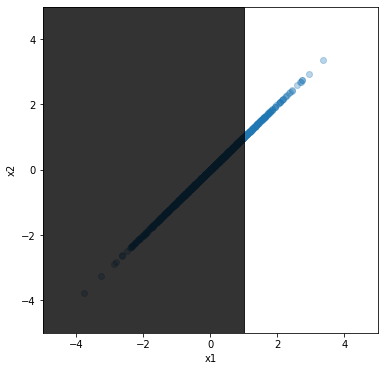

In [42]:
mu = [0.0, 0.0]
sigma1 = 1.0
sigma2 = 1.0
covariance = 1.0 # change this to one.
cov_matrix = np.array([
    [sigma1, covariance],
    [covariance, sigma2]
])
samples = pm.draw(pm.MvNormal.dist(mu=mu, cov=cov_matrix), 1000)

x1 = samples[:, 0]
x2 = samples[:, 1]

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.scatter(x1, x2, alpha=0.3)
ax.set_xlim([-5, 5])
ax.set_ylim([-5, 5])
ax.set_xlabel("x1");
ax.set_ylabel("x2");

ax.add_patch(Rectangle((-5, -5), 6, 10, alpha=0.8, color="k"));

When the covariance is equal to the variance, you can see that the word "usually" turns into the word "always".  $x1 = x2$, or, if I tell you what the value of $x1$ is, you'll be able to tell me the value of $x2$. 

The best way to really understand this is to experiment.  Try choosing different values for the mean `mu`, the dimension 1 variance, the dimension 2 variance and the covariance, and then draw and plot the samples.  Here are a few important characteristics that you'll see:

- Increasing the variances stretch the distribution, but only in that particular dimension
- The variances on the diagonal must be positive
- The covariance can be negative or positive
- When you pick covariance values that are larger than the variances, you'll get a long stack trace and some message about the matrix not being positive semi-definite.  This is a mathematical condition that just means you're out of bounds with your choice of covariance.  When you get this error, decrease the value of the covariance that you just increased.

## Covariance and Correlation (TODO)
https://stats.stackexchange.com/a/413092

* Correlation is normalized version of covariance
* -1 means exact negative
* 1 means exact positive
* 0 means no relation
* While thats good to know, doesnt really matter for GPs

## Practical examples

Think about siblings and height.  Think of 100 pairs of siblings.  If a brother is taller than average, would you guess the sister is also more likely to be taller than average?  It's certainly not a guarantee, but it's probably more likely.  

Also, think about sales at a restaurant.  If there are a lot of customers during the lunch rush, from 12 noon to 1pm.  Are there likely to be a lot of customers in the next hour?  From 1 to 2pm?  The 12 to 1pm customer count is *at least* likely to be more similar to the 1 to 2pm count, than it is to the 3 to 4pm count.

## Section Recap
* Multivariate normals are an important case of randomness
* MVNs generate random vectors of size N
* MVNs are defined by $\mu$ and $\sigma$, but also covariance matrix
* Covariance, and correlation, specify degree of relation between pairwise variables or dimensions
* In real life many things are related
  * Sibling heights due genetics
  * The number of customers in two adjacent time slots in restaurants
  * Number of Intutive Bayes courses you take and your knowledge practical Bayesian usage


Hopefully the last one is positively correlated

# Sec 30: A different way to visualize multivariate normals: Seeing in N Dimensions

We can't really plot multivariate normal distributions that have more than three dimensions.  Even then, it's really not easy to see what's going on, it just looks like a formless blob of dots.  Let's try a new plot.  Instead of each dimension getting it's own axis, let's plot each dimension down the axis, as if they were sequential points in time.  Here's what I mean, in three dimensions:  

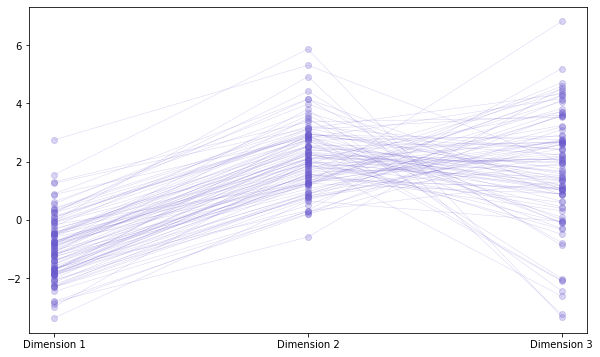

In [43]:
mu = [-1, 2, 2]

sigma1 = 1.0
sigma2 = 1.0
sigma3 = 3.0
covariance12 = 0.8
covariance13 = 0.1
covariance23 = -0.9

cov_matrix = np.array([
    [sigma1, covariance12, covariance13],
    [covariance12, sigma2, covariance23],
    [covariance13, covariance23, sigma3],
])
samples = pm.draw(pm.MvNormal.dist(mu=mu, cov=cov_matrix), 100)

dimension = np.arange(len(mu))

fig, ax = plt.subplots(1, 1, figsize=(10, 6));
ax.plot(dimension, samples.T, color="slateblue", lw=0.5, alpha=0.25, marker="o");
ax.set_xticks(dimension)
ax.set_xticklabels(["Dimension " + str(i) for i in dimension + 1]);

##### What does covariance look like in this context?

- When you go from dimension 1 to dimension 2, consider the value of `covariance12`.  It's positive, and the lines basically never cross each other. As the value in dimension one increases, so does the value in dimension 2.
- Look at dimension 2 to 3, and consider the value of `covariance23`.  It's negative, and basically every line crosses.  If it's relatively high in dimension 2, it goes down and is low in dimension 3, and visa versa. 
- What about `covariance13`?  It's here, but it's invisible in this plot.  It's doing something similar to `covariance12` and `covariance13`.  But, that's the thing about projecting a higher dimensional thing down into a lower dimensional space.  Things in higher dimensions do have real effects, but these effects are invisible from lower dimensional viewpoints.  The effects they produce are real, but the mechanism isn't apparent. 

Again, I encourage you to play with the numbers here and see what happens.  Nothing is stopping us from making this type of plots in even higher dimensions, even hundreds or thousands of dimensions is possible.  We'll make plots of Gaussian proceses that look like this many many times in this course!

## Multivariate normal wrap-up

The amount of knowledge out there on normal and multivariate normals is pretty vast.  A quick skim of the wikipedia page will tell you as much.  For now though, we'll redirect ourselves back towards building a Gaussian process.  We will return to multivariate normals in a later lesson after we fit our first GPs.  Multivariate normals are important because of two other key concepts, **marginalization** and **conditioning**.  

## Section Recap
* Multivariate Normals can, and often do, extend past 3 dimensions
* To visualize higher dimensions we can plot them in what's called a parallel plot
  * Each dimension is on the x axis
  * The y is the value of the random draws
  * A continuous line connects the vector of points together
  * These lines are not strictly parallel, making the plot name a bit unfortunate

# Sec 40: Remember kernels?

What if we used a kernel to generate the covariance matrix for a multivariate normal?  Remember the main takeaway from that lesson, kernel functions give the similarity of the points in $y$, depending on the points $x$ and $x'$.  *Isn't this kind of the same thing as the covariances bwetween elements in a multivariate normal?*  

Let's try it out.  Let's take our same exponentiated quadratic kernel from Art class, use it to calculate a 10 by 10 covariance matrix, and use it to draw samples from a multivariate normal.  

In [44]:
# Copy/paste our kernel function from the art class lesson
def kernel(x, x_prime, lengthscale):
    return np.exp( -0.5 * np.square(x - x_prime) / np.square(lengthscale))

x = np.arange(10)

# Calculate kernel/covariance matrix values for every possible pair of x values in the data
K = np.zeros((10, 10))
for i in range(10):
    for j in range(10):
        K[i, j] = kernel(x[i], x[j], lengthscale=2)
        
# Lets use a zero mean this time
mu = np.zeros(10)
    
# Draw samples from this random vector
random_vector = pm.MvNormal.dist(mu=mu, cov=K)
samples = pm.draw(random_vector, draws=10_000)

This is another example of a random vector where there are relationships between the different X's.  And of course, these relationships are determined by the kernel matrix.  

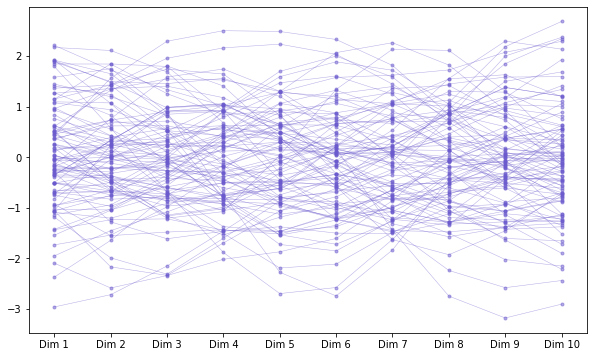

In [45]:
x = np.arange(len(mu))
fig, ax = plt.subplots(1,1,figsize=(10, 6))

# plot 100 of the samples
ix = np.random.randint(0, samples.shape[0], 100)
ax.plot(x, samples[ix, :].T, color="slateblue", lw=0.5, alpha=0.5, marker=".")

ax.set_xticks(x);
ax.set_xticklabels(["Dim " + str(i + 1) for i in range(len(x))]);

There's a very important quality to notice here, **smoothness**.  Just like in art class, the changes from point to point as we go from left to right are smooth.  Except now, we have multivariate normals in our toolbelt.  The combination of a kernel and a multivariate normal are the two primary ingredients in a Gaussian process.

**TODO**: 
* Put a non kernel covariance and covariance MVN draw side by side
* Highlight a random draw to show how "less" random the path looks when a kernel defines covariance

* Exercise idea: Give people a kernel, ask them to take random draws, and tell us "what the kernel is mapping to" For instance a periodic kernel

## Section Recap
* Kernels can be used to generate covariance matrices
  * Just like in art class, the kernel defines how "close" two dimensions should be
* Random vectors can be generated from covariance matrices and MVNs
  * This was quite evident once we compared to the parallel plots from the last section